In [163]:
from src.data_utils import load_xsum_dict, load_shuffled_test_split

xsum_test = load_xsum_dict("test")
bart_test_extrinsic = load_shuffled_test_split(xsum_test, "bart-test-extrinsic", len(xsum_test))
print(
    len(bart_test_extrinsic),
    len(bart_test_extrinsic) / len(xsum_test)
)
pegasus_test_extrinsic = load_shuffled_test_split(xsum_test, "pegasus-test-extrinsic", len(xsum_test))
print(
    len(pegasus_test_extrinsic),
    len(pegasus_test_extrinsic) / len(xsum_test)
)

Using custom data configuration default
Reusing dataset xsum (/Users/anton164/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

6823 0.6019940003529204
6988 0.6165519675313217


In [164]:
import pandas as pd
import json
import numpy as np


def read_logs(path):
    with open(
        path,
        "r"
    ) as f:
        iteration_logs = json.load(f)

    data = []
    edits_by_sum_id = {}
    for iteration in iteration_logs:
        for sum_id, sum_data in iteration["summary"].items():
            if "edit_stats" in sum_data and sum_id in xsum_test:
                if sum_id not in edits_by_sum_id:
                    edits_by_sum_id[sum_id] = {}
                edits_by_sum_id[sum_id]["token"] = sum_data["edit_stats"]["edit_distance_token"]
                # edits_by_sum_id[sum_id]["rouge1"] = sum_data["edit_stats"]["rouge1"]
                # edits_by_sum_id[sum_id]["rouge2"] = sum_data["edit_stats"]["rouge2"]
                # edits_by_sum_id[sum_id]["rougeL"] = sum_data["edit_stats"]["rougeL"]

        if iteration["iteration"] == 0 and "full" in path:
            for sum_id in xsum_test.keys():
                if sum_id not in edits_by_sum_id:
                    edits_by_sum_id[sum_id] = {}
                    edits_by_sum_id[sum_id]["token"] = 0

        result_obj = {
            "iteration": iteration["iteration"],
            "summary_factual": iteration["factuality_summary"]["factual"],
            "summary_non_factual": iteration["factuality_summary"]["non_factual"],
            "summary_unknown": iteration["factuality_summary"]["unknown"],
            "summary_failed": iteration["factuality_summary"]["failed"],
            "mean_edit_distance_token": np.mean(
                [x["token"] for x in edits_by_sum_id.values()]
            ),
            # "mean_edit_distance_rouge1": np.mean(
            #     [x["rouge1"] for x in edits_by_sum_id.values()]
            # ),
            # "mean_edit_distance_rouge2": np.mean(
            #     [x["rouge2"] for x in edits_by_sum_id.values()]
            # ),
            # "mean_edit_distance_rougeL": np.mean(
            #     [x["rougeL"] for x in edits_by_sum_id.values()]
            # )
        }
        data.append(result_obj)
    
    return pd.DataFrame(data).set_index("iteration"), iteration_logs, edits_by_sum_id

dataset = "bart-full"
df_clf, logs_clf, edits_clf = read_logs(
    f"results/iteration-changes/{dataset}-classifier-knnv1.json"
)

df_clf

,summary_factual,summary_non_factual,summary_unknown,summary_failed,mean_edit_distance_token
iteration,,,,,
0,0.394124,0.022234,0.583642,0,0.000000
1,0.431975,0.020999,0.547027,53,1.942209
2,0.446003,0.035821,0.518175,243,2.186783
3,0.453503,0.049674,0.496824,413,2.308276
4,0.455267,0.090524,0.454209,891,2.325746
5,0.455797,0.100141,0.444062,1009,2.333333
6,0.456326,0.105259,0.438415,1068,2.330157
7,0.456326,0.107023,0.436651,1089,2.328304
8,0.456414,0.107817,0.435768,1097,2.328657


In [244]:
edit_distances = []
for x in edits_clf.values():
    if x["token"] != 0:
        edit_distances.append(x["token"])
edit_distance_weights = np.ones_like(edit_distances)/float(len(edit_distances))
edit_distance_weights


print(len(edit_distances))

3565


Text(0.5, 95.75520000000006, 'Word Edit Distance')

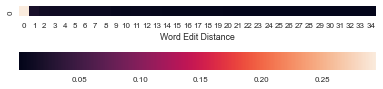

In [166]:
import seaborn as sns
ax = sns.heatmap(
    np.unique(edit_distances, return_counts=True)[1].reshape(1, -1) / np.sum(edit_distances),
    cbar_kws={"orientation": "horizontal"},
    square=True
)
ax.set_xlabel("Word Edit Distance")
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
# ax.spines['bottom'].set_visible(False)
# ax.spines['top'].set_visible(True)

In [25]:
np.unique(edit_distances, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 35,
        36]),
 array([3404,  481,  329,  316,  266,  230,  223,  211,  183,  149,  113,
         142,  121,   98,   78,   88,   60,   59,   59,   60,   52,   30,
          22,   12,   18,    5,    4,    2,    1,    2,    1,    1,    1,
           1,    1]))

<AxesSubplot:ylabel='Count'>

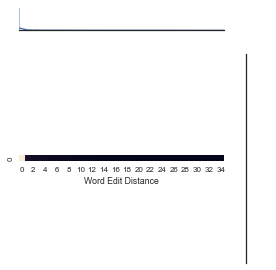

In [167]:
normed_edits = np.unique(edit_distances, return_counts=True)[1].reshape(1, -1) / np.sum(edit_distances)
g = sns.JointGrid(height=4, space=1)
ax = sns.heatmap(
    np.unique(edit_distances, return_counts=True)[1].reshape(1, -1) / np.sum(edit_distances),
    cbar=False,
    #cbar_kws={"orientation": "horizontal"},
    square=True,
    ax=g.ax_joint
)
ax.set_xlabel("Word Edit Distance")
#sns.kdeplot(edit_distances, linewidth=2, ax=g.ax_marg_x)
sns.histplot(
    edit_distances,
    #fit=norm,
    kde=True,
    ax=g.ax_marg_x
)

In [170]:
np.unique(
    edit_distances,
    return_counts=True
)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 35,
        36]),
 array([7769,  502,  339,  331,  278,  238,  236,  224,  192,  151,  116,
         145,  128,  102,   83,   92,   62,   63,   63,   62,   52,   31,
          24,   12,   18,    5,    5,    2,    2,    2,    1,    1,    1,
           1,    1]))

In [175]:
(np.unique(edit_distances, return_counts=True)[1] / len(edit_distances))[0]

0.685459678842421

3565 0.31454032115757896


<AxesSubplot:xlabel='Word Edit Distance', ylabel='Density'>

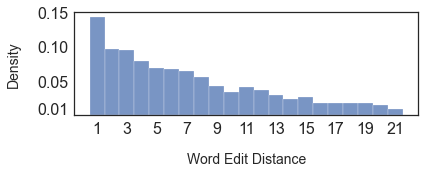

In [279]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

sns.set_theme()
sns.set_context("paper")
mpl.style.use(["seaborn-white", "seaborn-paper"])
# sns.set_style("white")
# plt.rcParams["axes.grid"] = True
plt.rcParams["patch.force_edgecolor"] = True
plt.figure(figsize = (6,2.5))
ax = sns.histplot(
    edit_distances,
    bins=np.arange(1, 23) - 0.5,
    #bins=np.array([0, 1, 2, 3, 4, 5, 6, 11, 16, 21, 22]) - 0.5,
    stat="density",
    # discrete=True,
    # kde=True,
    # kde_kws={'clip': (1.5, 40)}
)
# plt.hlines(0.152, -0.5, 0.5, color='lightgray', linewidth=33.5)
#rect = ax.patches.Rectangle((10, 10), , linewidth=1, edgecolor='r', facecolor='none')
#ax.add_patch(rect)
ax.set_xticks(range(1, 22, 2))
ax.set_xlabel("Word Edit Distance", fontsize=14, labelpad=16)
ax.set_ylabel("Density", fontsize=14, labelpad=16)
#ax.set_yscale('log')
ax.yaxis.set_ticks([0.01, 0.05, 0.1, 0.15])
# ax.set_ylim(0, 0.2)
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig("plots/word_distance.pdf")
print(len(edit_distances), len(edit_distances) / len(xsum_test))
ax

In [111]:
np.arange(0, 23)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

Text(0.5, 0, 'Word edit distance')

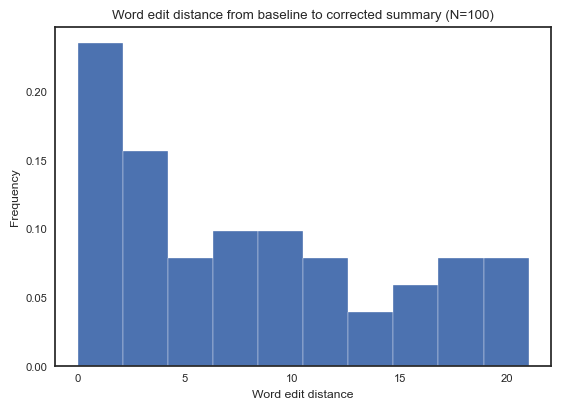

In [255]:
import matplotlib as mpl
mpl.style.use(["seaborn-white", "seaborn-paper"])
#define style
#sns.set_theme()
fig, ax = plt.subplots()
ax.hist(
    edit_distances, 
    weights=edit_distance_weights
)
ax.set_title("Word edit distance from baseline to corrected summary (N=100)")
ax.set_ylabel("Frequency")
ax.set_xlabel("Word edit distance")

In [212]:
# Paper plots
import matplotlib as mpl
mpl.style.use(["seaborn-white", "seaborn-paper"])
#define style
mpl.style.use('default')
style = {
        "pgf.rcfonts":False,
        # "pgf.texsystem": "pdflatex",   
        "text.usetex": False,                
        "font.family": "serif",
        "font.serif": "Times"
        }
#set
mpl.rcParams.update(style)

In [209]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

# Be sure to only pick integer tick locations.
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.plot(
    df_clf.index,
    df_clf.summary_factual,
    label="BART + FBS"
)
ax.plot(
    df_oracle.index,
    df_oracle.summary_factual,
    label="BART + FBS Oracle"
)
ax.margins(0.05)
ax.axis('tight')
fig.tight_layout()
plt.ylabel("Factual Summaries")
plt.xlabel("Max number of Iterations")
plt.legend()
# TODO change to histogram to show how many iterations it takes on average
# Seaborn paper mode

FileNotFoundError: missing font metrics file: ptmr7t

FileNotFoundError: missing font metrics file: ptmr7t

<Figure size 640x480 with 1 Axes>

In [91]:
# sns.displot(df_clf.summary_factual, kind="ecdf")

In [5]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Factual", "Non-Factual", "B1", "B2", "C1", "C2"],
      color = "green"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Entity Changes", font_size=10)
fig.show()

In [2]:
import plotly.graph_objects as go
import urllib, json

url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())

# override gray link colors with 'source' colors
opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
                                    for src in data['data'][0]['link']['source']]
print(data)
fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    valuesuffix = "TWh",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  data['data'][0]['node']['label'],
      color =  data['data'][0]['node']['color']
    ),
    # Add links
    link = dict(
      source =  data['data'][0]['link']['source'],
      target =  data['data'][0]['link']['target'],
      value =  data['data'][0]['link']['value'],
      label =  data['data'][0]['link']['label'],
      color =  data['data'][0]['link']['color']
))])

fig.update_layout(title_text="Energy forecast for 2050<br>Source: Department of Energy & Climate Change, Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
                  font_size=10)
fig.show()

{'data': [{'type': 'sankey', 'domain': {'x': [0, 1], 'y': [0, 1]}, 'orientation': 'h', 'valueformat': '.0f', 'valuesuffix': 'TWh', 'node': {'pad': 15, 'thickness': 15, 'line': {'color': 'black', 'width': 0.5}, 'label': ["Agricultural 'waste'", 'Bio-conversion', 'Liquid', 'Losses', 'Solid', 'Gas', 'Biofuel imports', 'Biomass imports', 'Coal imports', 'Coal', 'Coal reserves', 'District heating', 'Industry', 'Heating and cooling - commercial', 'Heating and cooling - homes', 'Electricity grid', 'Over generation / exports', 'H2 conversion', 'Road transport', 'Agriculture', 'Rail transport', 'Lighting & appliances - commercial', 'Lighting & appliances - homes', 'Gas imports', 'Ngas', 'Gas reserves', 'Thermal generation', 'Geothermal', 'H2', 'Hydro', 'International shipping', 'Domestic aviation', 'International aviation', 'National navigation', 'Marine algae', 'Nuclear', 'Oil imports', 'Oil', 'Oil reserves', 'Other waste', 'Pumped heat', 'Solar PV', 'Solar Thermal', 'Solar', 'Tidal', 'UK land